# C4AI Scholars Program Takehome Challenge


### Background

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of three parts:

* Part One of the challenge requires identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
* Part Two of the challenge tests your ability to generate code for a specified problem.
* Part Three of the challenge is an opportunity for you to attempt an optional challenge question that extends the original problem set.


These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources.

Good luck! If you have questions about the framing of the questions, please contact info@for.ai  


### How to Use and Submit this Document

* **Make a copy of this document** and **rename** it **Firstname_Lastname_C4AIScholarsChallenge**
* Once you’ve completed all tasks, **save and pin your revisions**
* **Submit a link** to your final document via the [Cohere For AI Scholars Program application](https://jobs.lever.co/cohere/?department=Cohere%20For%20AI).



---



## Overview of Singular Value Decomposition

In this takehome, you will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors.

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

#### Q1: What are some real world applications of low rank approximations?


#### Answer:
- PCA (principal component analysis) is a form of low rank approximation used
  for dimensionality reduction. PCA can describe a high-dimensional dataset
  with  small number of dimensions while preserving maximum variance of the
  original data. Often used for visualization.
- Recommender systems uses low rank approximation to decompose user-item matrix
  into low rank user and item embedding matrices that are then used to compute
  the recommendations.
- Topic modelling is an application of low rank approximation very similar to
  recommender systems. It uses word-document matrix.


#### Q2: What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?

#### Answer:
The main benefits are:
- **Smaller memory footprint** - It can be measured as the ratio of the
  compressed and the original model size using either bytes or parameter count.
- **Inference speedup** - It can be measured as the number of FLOPS or the
  total time required to compute the inference.

Different compression methods require different metrics. For example, quantizing a model to float16 decreases the size in bytes but the parameter count stays the same.


#### Q3: In this takehome, we will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? Choose one or two alternative compression methods and compare with singular value decomposition.

#### Answer:
- SVD cannot easily decompose convolutional layers and other
  $\mathbb{R}^{n_1\times n_2\dots\times n_n}$ tensors. Quantization
  can be applied to any type of layer.
- Prunning methods needs to be applied during the training. SVD can be used at
  any time after the training is done.



---



### Imports

In [ ]:
!pip install dm-haiku optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 350 kB 15.3 MB/s 
     |████████████████████████████████| 145 kB 63.5 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 


In [ ]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## Coding Challenge Part I : Debugging Challenge (10 Points)


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. You are using a very simple toy model as a first baseline. Section 3 will give you the chance to improve baseline accuracy beyond this very simple model -- this is just a toy setting to first explore low rank approximations.

The first part of this challenge is primarily a debugging challenge. It will require removing bugs in order to train a very simple network. We have introduced several bugs -- some are subtle and will not break your code but will degrade final performance. These subtle bugs are introduced to understand your grasp of fundamental machine learning principles. There are also more obvious bugs designed to break your code.

* [**4 points**] Your goal is to get the code working. There are 4 bugs in the code, these are subtle bugs which are designed to impair test accuracy but not break the code. You will get partial points for each of the 4 bugs you find. After finding all bugs, your test performance should be around 66-67% test accuracy.

* [**2 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.

* [**4 points**] There are also two functions you will need to code up in this section -- we indicate where these code changes need to happen with TODO comments.

* Do not alter the model architecture or the learning rate.

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
  """
  Network forward pass definition. This function needs to be passed to
  `haiku.transform` to create pure `apply` and `init` functions.

  Example:
  ```python
  net = hk.transform(net_fn)
  params = net.init(0, batch)
  logits = net.apply(params, 0, batch)
  ```

  Args (when transformed to `apply`):
    batch: Tuple of two arrays. The first array `shape=(batch_size, 32, 32, 3)`
      contains the images. The second array `shape=(batch_size,)` stores the
      labels.
  Returns (when transformed to `apply`):
    Array `shape=(batch_size, 10)` of non-normalized scores (logits) for each
    label and each image in the `batch`.
  """

  x = normalize(batch[0])

  # Do NOT alter the architecture definition below.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """
  Loads CIFAR10 dataset as a generator of batches. The data in the generator
  are repeated indefinitely.

  Args:
    split: What part of the dataset to load. Examples are `test`, `train[:80%]`.
      Additional details: https://www.tensorflow.org/datasets/splits#slicing_api
    is_training: If `True`, the dataset is shuffled.
    batch_size: Number of images in each batch.
  Returns:
    Infinite batch generator. Each entry in the generator is a
    tuple of two arrays and represents one batch. The first array
    `shape=(batch_size, 32, 32, 3)` contains the images.
    The second array `shape=(batch_size,)` stores the labels.
  """
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
    # ds = ds.shuffle(50_000, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """
  Computes the loss of the network for given `params` and data `batch`.
  The loss consists of cross-entropy data loss and L2 regularization loss.

  Args:
    params: Model parameters, dictionary where each entry stores weights
      and biases of one model layer.
    batch: Tuple of two arrays. The first array `shape=(batch_size, 32, 32, 3)`
      contains the images. The second array `shape=(batch_size,)` stores the
      labels.
  Returns:
    Array `shape=()` (scalar value) with the loss.
  """
  x, y = batch
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  # TODO: add code below to compute the l2_loss variable
  # L2 loss is the total sum of squares of all model parameters.
  l2_loss = sum(
    (w_or_b ** 2).sum()
    for layer in params.values()
    for w_or_b in layer.values()
  )

  weighted_l2_loss = 0.5 * l2_loss

  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))

  # BUG 1: L2 loss needs to be added to the softmax loss, not substracted.
  # `weighted_loss` instead of `l2_loss` should be used.
  # return softmax_xent - (1e-4 * l2_loss)
  return softmax_xent + (1e-4 * weighted_l2_loss)

@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """
  Computes the accuracy of the network for given `params` and data `batch`.

  Args:
    params: Model parameters, dictionary where each entry stores weights
      and biases of one model layer.
    batch: Tuple of two arrays. The first array `shape=(batch_size, 32, 32, 3)`
      contains the images. The second array `shape=(batch_size,)` stores the
      labels.
  Returns:
    Array `shape=()` (scalar value) with the accuracy.
  """
  predictions = net.apply(params, batch)

  # TODO: add code below to compute the accuracy over the batch.
  # For each prediction, get the index of the largest score.
  # Labels are 0-9 -> the index is equal to the predicted label.
  predicted_labels = predictions.argmax(axis=1)
  _, true_labels = batch
  # Accuracy is the share of correct predictions.
  accuracy = (true_labels == predicted_labels).mean()
  return accuracy

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """
  Performs one update of the model parameters.
  - Computes the gradient of the loss function at the current position.
  - Generates a parameter update from the gradient (using Adam) and applies it.

  Args:
    params: Model parameters, dictionary where each entry stores weights and
      biases of one model layer.
    opt_state: Current state of the optimizer.
    batch: Tuple of two arrays. The first array `shape=(batch_size, 32, 32, 3)`
      contains the images. The second array `shape=(batch_size,)` stores the
      labels.
  Returns:
    Tuple with the updated `params` and `opt_state`.
  """
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """
  Tracks a moving average of the model parameters from the previous
  training steps. It updates the current average `avg_params` with
  the new `params`.

  Args:
    params: New model parameters.
    avg_params: Current parameter average.
  Returns:
    Updated parameter average.
  """
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  """
  Converts a batch of `images` from `uint8` to `float32` and
  normalizes the data to mean=0 and std=1. Training `std` and `mean`
  are precomputed.

  Args:
    images: Batch of images `shape=(batch_size, 32, 32, 3)`.
  Returns:
    Normalized batch (same shape as `images`).
  """
  mean = np.asarray(CIFAR10_MEAN)
  std = np.asarray(CIFAR10_STD)
  # BUG 2: Converting from an unsigned (max value 255) to signed (max value 127)
  # 8-bit integer causes an overflow. For example, 168 converts to -88.
  # We can cast to `float32` instead.
  x = images.astype(jnp.float32) / 255.
  # BUG 3: `x /- mean` is not an assignment, just an expression,
  # `x` would remain unchanged.
  x -= mean
  x /= std

  return x

### Training

In [ ]:
net = hk.without_apply_rng(hk.transform(net_fn))

# Do not change learning rate
opt = optax.adam(1e-3)

# BUG 4: Training should use 80% of the training split, 20% for validation.
train = load_dataset("train[0%:80%]", is_training=True, batch_size=1000)
validation = load_dataset("train[80%:]", is_training=False, batch_size=10000)
test = load_dataset("test", is_training=False, batch_size=10000)

params = avg_params = net.init(jax.random.PRNGKey(42), next(train))
opt_state = opt.init(params)


for step in range(10001):
  if step % 1000 == 0:
    val_accuracy = compute_accuracy(avg_params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))
    val_accuracy, test_accuracy = jax.device_get(
        (val_accuracy, test_accuracy))
    print(f"[Step {step}] Validation / Test accuracy: "
          f"{val_accuracy:.3f} / {test_accuracy:.3f}.")

  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteS0OYNF/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteS0OYNF/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
[Step 0] Validation / Test accuracy: 0.101 / 0.103.
[Step 1000] Validation / Test accuracy: 0.476 / 0.480.
[Step 2000] Validation / Test accuracy: 0.606 / 0.611.
[Step 3000] Validation / Test accuracy: 0.618 / 0.626.
[Step 4000] Validation / Test accuracy: 0.619 / 0.630.
[Step 5000] Validation / Test accuracy: 0.620 / 0.623.
[Step 6000] Validation / Test accuracy: 0.621 / 0.622.
[Step 7000] Validation / Test accuracy: 0.620 / 0.620.
[Step 8000] Validation / Test accuracy: 0.622 / 0.618.
[Step 9000] Validation / Test accuracy: 0.620 / 0.623.
[Step 10000] Validation / Test accuracy: 0.620 / 0.620.


## Coding Challenge Part 2: Compression through Low Rank Approximation (8 points)

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.

* [**4 points**] You will need to add code to define both the compute_eval_metrics and rank_approximated weight function.
* [**4 points**] Q4 and Q5 are worth 2 points each.

In [ ]:
def compute_eval_metrics(params, batch, n_samples):
# TODO: add code to compute the time for inference.
  duration_list = []
  accuracy_list = []
  for _ in range(n_samples):
    # I factored out the accuracy evaluation and record just the
    # `net.apply` inference time.

    # JAX's asynchronous dispatch requires using `.block_until_ready()`
    # when benchmarking execution time. It will block the main process until
    # the results are computed and ready to be returned. Without it, we would
    # measure just the time it takes to dispatch the computation.
    start = time.time()
    # TODO: add code to correctly compute the accuracy on a given batch.
    predictions = net.apply(params, batch).block_until_ready()
    duration = time.time() - start
    acc = (batch[1] == predictions.argmax(axis=1)).mean()
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

In [ ]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  # TODO: replace the code below with code to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.

  # To get the low-rank approximation, we compute SVD and use:
  # - the first k column vectors from `u`
  # - the first k row vectors from `v`
  # - the first k singular values from `s`
  # We then multiply `u @ s` to get two matrices in total:
  # `u @ s` (m x k) and `v` (k x n)
  u, s, v = jax.numpy.linalg.svd(weight, full_matrices=False)
  k = round(len(s) * rank_fraction)
  u = u[:, :k] @ jax.numpy.diag(s[:k])
  v = v[:k, :]

  return u, v

### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy. Firstly, add code for the rank_approximated_weight and add code to correctly compute the time for inference (the duration).

In [ ]:
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50
  # TODO: complete coding the compute_eval_metrics function to compute the time taken for inference.
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(latency):.4f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

Evaluating the model at 1.0
Rank Fraction / Test accuracy: 1.00 / 0.601.
Rank Fraction / Duration: 1.00 / 0.7448.
Evaluating the model at 0.9
Rank Fraction / Test accuracy: 0.90 / 0.600.
Rank Fraction / Duration: 0.90 / 0.7419.
Evaluating the model at 0.8
Rank Fraction / Test accuracy: 0.80 / 0.599.
Rank Fraction / Duration: 0.80 / 0.7567.
Evaluating the model at 0.7000000000000001
Rank Fraction / Test accuracy: 0.70 / 0.593.
Rank Fraction / Duration: 0.70 / 0.7368.
Evaluating the model at 0.6000000000000001
Rank Fraction / Test accuracy: 0.60 / 0.593.
Rank Fraction / Duration: 0.60 / 0.7364.
Evaluating the model at 0.5000000000000001
Rank Fraction / Test accuracy: 0.50 / 0.582.
Rank Fraction / Duration: 0.50 / 0.7393.
Evaluating the model at 0.40000000000000013
Rank Fraction / Test accuracy: 0.40 / 0.554.
Rank Fraction / Duration: 0.40 / 0.7375.
Evaluating the model at 0.30000000000000016
Rank Fraction / Test accuracy: 0.30 / 0.492.
Rank Fraction / Duration: 0.30 / 0.7532.
Evaluating 

### Q4: What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis). You should use the ranks_and_accuracies list computed above.

Answer: **The test accuracy drops as the rank fraction gets smaller because the lower the rank, the more information is lost when approximating the original parameters.**

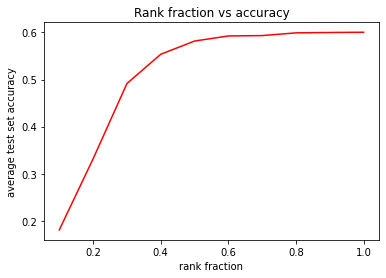

In [ ]:
## TODO: add your code below to plot the relationship between time and test set accuracy
x, y = list(zip(*ranks_and_accuracies))
plt.plot(x, y, "r")
plt.xlabel("rank fraction")
plt.ylabel("average test set accuracy")
plt.title("Rank fraction vs accuracy")
plt.show()

### Q5: Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis). To do so add code to compute the ranks_and_times list.

Answer: **There is no clear relationship between the rank fraction and the inference time. This makes sense because each approximated parameter matrix $U_kS_kV_k$ have always the same shape $m \times n$ as the original matrix regardless of the rank fraction. The total number of parameters of the model does not change and the inference time is not affected.**

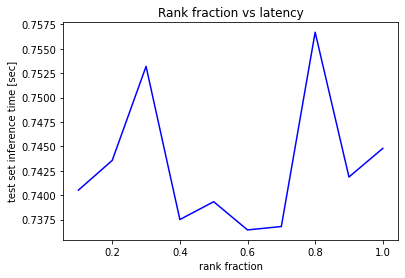

In [ ]:
## TODO: add your code below to plot the relationship between time and rank percentage
x, y = list(zip(*ranks_and_times))
plt.plot(x, y, "b")
plt.xlabel("rank fraction")
plt.ylabel("test set inference time [sec]")
plt.title("Rank fraction vs latency")
plt.show()

## Coding Challenge Part 3: Perform evaluations on the dataset in factorized space. (4 points)

In this section, you will perform evaluations on the dataset in factorized space.

* [**4 points**] 2 pts for question 6 and question 7.

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:

  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False),
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False),
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 1000), with_bias=False),
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial))
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at {rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction)
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']

  # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.4f}.")

Evaluating the model at 1.00
Rank Fraction / Test accuracy: 1.00 / 0.601.
Rank Fraction / Duration: 1.00 / 0.8612.
Evaluating the model at 0.90
Rank Fraction / Test accuracy: 0.90 / 0.600.
Rank Fraction / Duration: 0.90 / 0.8336.
Evaluating the model at 0.80
Rank Fraction / Test accuracy: 0.80 / 0.599.
Rank Fraction / Duration: 0.80 / 0.7955.
Evaluating the model at 0.70
Rank Fraction / Test accuracy: 0.70 / 0.593.
Rank Fraction / Duration: 0.70 / 0.7623.
Evaluating the model at 0.60
Rank Fraction / Test accuracy: 0.60 / 0.593.
Rank Fraction / Duration: 0.60 / 0.7404.
Evaluating the model at 0.50
Rank Fraction / Test accuracy: 0.50 / 0.582.
Rank Fraction / Duration: 0.50 / 0.7053.
Evaluating the model at 0.40
Rank Fraction / Test accuracy: 0.40 / 0.554.
Rank Fraction / Duration: 0.40 / 0.6835.
Evaluating the model at 0.30
Rank Fraction / Test accuracy: 0.30 / 0.492.
Rank Fraction / Duration: 0.30 / 0.6675.
Evaluating the model at 0.20
Rank Fraction / Test accuracy: 0.20 / 0.332.
Rank F

### Q6: Plot a curve showing time vs rank percentage of the matrix

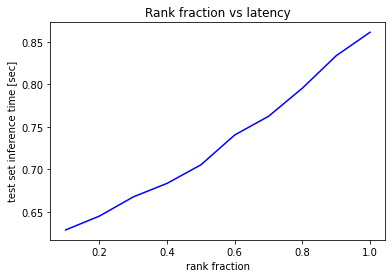

In [ ]:
# TODO: add code to plot the relationship between time vs percentage rank of the matrix.
x, y = list(zip(*ranks_and_times))
plt.plot(x, y, "b")
plt.xlabel("rank fraction")
plt.ylabel("test set inference time [sec]")
plt.title("Rank fraction vs latency")
plt.show()

### Q7: What do you observe between time and the percentage rank of the matrix.

### Put your answer here:

We observe a decrease in the inference time as the rank fraction gets smaller. We are using a different network architecture where we replace each original $mn$ parameter layer with two linear layers containing $mk + kn$ approximated parameters in total.

For `rank_fraction = 1.0`, **the latency is higher compared to the original model because the actual parameter count is higher as well**. The following table uses the first model layer $6144 \times 3000$
as an example to illustrate why:

| Model               | First layer k                             | First layer param count              |
|---------------------|-------------------------------------------|--------------------------------------|
| Original            |                                           | 6144 * 3000 = 18432000               |
| Rank fraction = 1   | k = min(m,n) = min(6144,3000) = 3000      | 6144 * 3000 + 3000 * 3000 = 27432000 |
| Rank fraction = 0.1 | k = 0.1min(m,n) = 0.1min(6144,3000) = 300 | 6144 * 300 + 300 * 3000 = 2743200    |

We achieve an overall latency improvement over the original model **only when the rank fraction is sufficiently small**.



---



## Coding Challenge Part 4: Take this Further (10 bonus points)

This part of the challenge is designed to be open ended. If you wanted to show some more skills, here is your chance to shine. We include two options below -- **only do one of the options**:

**Option 1:** Implement a change that isn't SVD but minimizes inference latency while preserving accuracy. Can you outperform SVD?



**Option 2:** Improve the quality of code for this takehome. Pretend you are reviewing a peer and add comments to cells with suggestions of how to improve the code quality. Try and make your comments action orientated and precise.


**For Option 1, DO NOT alter the previous code sections, instead add any new code below. You should not need to add new code for Option 2, instead just add comments to cells.**


### **Option 1: Using a mixed precision policy**

In [ ]:
# We can speed up the inference by converting the model parameters to float16.
# This can be done by setting up a mixed precision policy using `jmp` package.
# I had some issues getting the convolution layers to work with float16 so
# only the linear layers are converted.

# It is another tradeoff between the inference latency and accuracy because
# we are losing information by casting float32 to float16. It is a form
# of lossy compression (quantization).

import jmp
policy = jmp.get_policy("params=float16,compute=float16,output=float16")
hk.mixed_precision.set_policy(hk.Linear, policy)
# Keeps the convolution params in float32
policy = jmp.get_policy("params=float32,compute=float32,output=float16")
hk.mixed_precision.set_policy(hk.Conv2D, policy)

net = hk.without_apply_rng(hk.transform(net_fn))

In [ ]:
b = next(test)

In [ ]:
net.apply(params, b).dtype

dtype('float16')

In [ ]:
# float16 evaluation
test_accuracy, duration = compute_eval_metrics(params, b, 50)
print(f"Test accuracy: {np.mean(test_accuracy):.3f}.")
print(f"Duration: {np.mean(duration):.4f} seconds.")

Test accuracy: 0.601.
Duration: 0.6021 seconds.


In [ ]:
# Resets the policies back to float32.
hk.mixed_precision.clear_policy(hk.Linear)
hk.mixed_precision.clear_policy(hk.Conv2D)

In [ ]:
net.apply(params, b).dtype

dtype('float32')

In [ ]:
# float32 evaluation
test_accuracy, duration = compute_eval_metrics(params, b, 50)
print(f"Test accuracy: {np.mean(test_accuracy):.3f}.")
print(f"Duration: {np.mean(duration):.4f} seconds.")

Test accuracy: 0.601.
Duration: 0.7617 seconds.


#### **Conclusion**:
There is **an improvement in the average inference time** when using float16 (0.60 vs 0.76 seconds) while **the test accuracy remains the same**.

## You have made it to the end of the challenge!

Before you submit your completed challenge document, please make sure to **save and pin your revisions** before submitting a link to your submission via the [Cohere For AI Scholars Program Application.](https://jobs.lever.co/cohere/)